<a href="https://colab.research.google.com/github/sunnys-lab/xray_classification_with_tpus/blob/main/medical_image_classification_20220628.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Classification on Google Colab

2022-06-28 이기선

##00.개요

본 예제는 간단한 이미지 분류 알고리즘을 이용하여 폐엑스레이 영상을 정상과 폐렴으로 분류하는 모델을 만드는 실습

TPU 학습을 위해서는 데이터가 Google Cloud 에 저장 되어 있어야 하고, Google Cloud 에 저장되어 있는 데이터를 자겨 올 수 있는 링크가 필요합니다.
본 예제를 TPU에서 실행하려면 Colab의 런타임 유형이 "TPU"로 설정되어 있어야 합니다.

(Colab의 런타임 유형이 "TPU"로 설정하는 방법: 상단 메뉴바에서 "런타임" > "런타임유형변경" > "하드웨어가속기" > "TPU" 선택)

### ALU (arithmetic and logical unit,산술논리연산장치)
머신러닝 및 딥러닝 알고리즘은, 많은 양의 단순 사칙연산(행렬 곱셈 등)을 수행.

단순 사칙연산은 병렬화가 가능하기 때문에, ALU 가 많다면, 사칙연산을 병렬화함으로써, 머신러닝 및 딥러닝을 보다 효율적으로 최적화 가능  
<br/>  

### CPU (Central Processing Unit, 중앙연상장치)
‘Central Processing Unit’의 약자, 컴퓨터의 모든 연산과 작업을 처리하는 장치

CPU 의 ALU 는 1자리수

단순 사칙연산 속도가, GPU 에 비해 안 좋으나, 복잡한 연산에는 용이    
<br/>  



### GPU (Graphical Processing Unit, 그래픽 연산장치)

그래픽 연산 처리를 위해 개발

GPU 의 ALU 는 성능에 따라 다르지만 일반적으로 1000개 이상

ALU 의 개수가 CPU 보다 많기 때문에, CPU 에 비해 단순 사칙연산 속도가 빠름    
<br/>  


### TPU (Tensor Processing Unit, 텐서 연상장치)
Google 이 자체적으로 개발한 연산장치

Google 의 오픈 소스 머신 러닝 프레임워크인 TensorFlow 맞춤형 집적 회로

TPU 의 ALU 는 약 3만개

TPU 는 벡터 / 행렬연산에 용이하도록, ALU 의 위치별 용도가 미리 설계

## 01.초기설정

In [1]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Device: grpc://10.109.106.218:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.109.106.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.109.106.218:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of replicas: 8


In [2]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
print("BATCH_SIZE: ", BATCH_SIZE)
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

BATCH_SIZE:  200


## 02.데이터 로드

In [3]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)

train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [4]:
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)

print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1349
Pneumonia images count in training set: 3883


In [5]:
def get_label(file_path):
    # 전체 파일 경로를 "/" 를 기준으로 분리
    parts = tf.strings.split(file_path, "/")
    # 분리된 파일 경로명에서 마지막 에서 두번째 부분이 class-directory 이름
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    # 스트링형태의 데이터를 3D 형태의 텐서 데이터로 변환(
    img = tf.image.decode_jpeg(img, channels=3)
    # 이미지 크기를 원하는 사이즈로 리자이징
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    # 이미지의 라벨 확인
    label = get_label(path)
    # 스트링 형태의 로우 데이터를 이미지데이터로 변환
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [6]:
ds = ds.shuffle(10000)
train_ds = ds.take(5000)
val_ds = ds.skip(5000)

In [7]:
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False


In [8]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

## 03.데이터 전처리 및 시각화

In [9]:
def prepare_for_training(ds, cache=True):
    # 본 실습에서 사용하는 데이터 셋은 크기가 크지 않기 때문에,
    # 데이터셋을 메모리에 로드하여 학습을 진행 합니다.
    # `.cache(filename)` 코드는 메모리에 맞지 않는 데이터셋의 경우 
    # 전처리(preprocessing) 작업이 발생할 수 있도록 하는 코드 입니다.
    # Tensorflow Core 설명에 따르면, .cache()는 첫 번째 epoch 동안 디스크에서 
    # 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 
    # 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 
    # 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 
    # 캐시를 생성할 수도 있습니다.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` 코드는 학습이 진행되는 동안 fetch 배치 작업이 백드라운드에서
    # 발생할 수 있도록 하는 코드 입니다. 
    # 버퍼 사이즈는 자동으로 설정되도록 하였습니댜.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [10]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [11]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

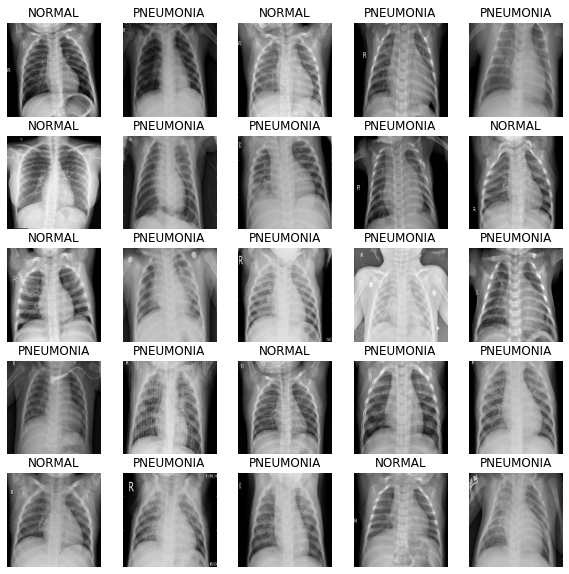

In [12]:
show_batch(image_batch.numpy(), label_batch.numpy())

## 04.합성곱신경망 생성 (Convolutional Neural Network)

In [13]:
from tensorflow import keras
from tensorflow.keras import layers


def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

In [14]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## 05.데이터 불균형 보정

CNN 을 통한 학습시 class 0 (정상)에 해당되는 이미지 수가 더 적기 떄문에 해당 class에 적용되는 weight값이 class 1(폐렴)에 적용되는 weight값보다 높게 적용

In [15]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


## 06.모델학습 (Training)

학습이 이루어 질 떄마다 다음 학습에 효율성을 높이기 위해 최대 성능을 내는 모델 weight가 저장 되도록 checkpoint를 설정.

조기 중지 콜백은 모델이 정체되기 시작하거나 더 심하게 모델이 과적합되기 시작할 때 훈련 프로세스를 중지.

In [16]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

학습률의 경우 학습률이 너무 높으면 모델이 발산되거나 학습률이 너무 작으면 모델이 너무 느려지기 떄문에, 아래의 지수 학습률 스케줄링 방법으로 구현

In [17]:
initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [18]:
with strategy.scope():
    model = build_model()

    METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/50
25/25 [==============================] - 32s 481ms/step - loss: 0.5518 - binary_accuracy: 0.7094 - precision: 0.9077 - recall: 0.6778 - val_loss: 5.0242 - val_binary_accuracy: 0.2759 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
25/25 [==============================] - 6s 226ms/step - loss: 0.2815 - binary_accuracy: 0.8880 - precision: 0.9614 - recall: 0.8848 - val_loss: 0.9342 - val_binary_accuracy: 0.7284 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 3/50
25/25 [==============================] - 3s 135ms/step - loss: 0.1988 - binary_accuracy: 0.9240 - precision: 0.9739 - recall: 0.9225 - val_loss: 1.0468 - val_binary_accuracy: 0.5690 - val_precision: 1.0000 - val_recall: 0.4048
Epoch 4/50
25/25 [==============================] - 4s 175ms/step - loss: 0.1836 - binary_accuracy: 0.9302 - precision: 0.9789 - recall: 0.9260 - val_loss: 0.4353 - val_binary_accuracy: 0.8276 - val_precision: 1.0000 - val_recall: 0.7619
Epoch 5/50
25/25 [=====================

##07.학습과정의 시각화

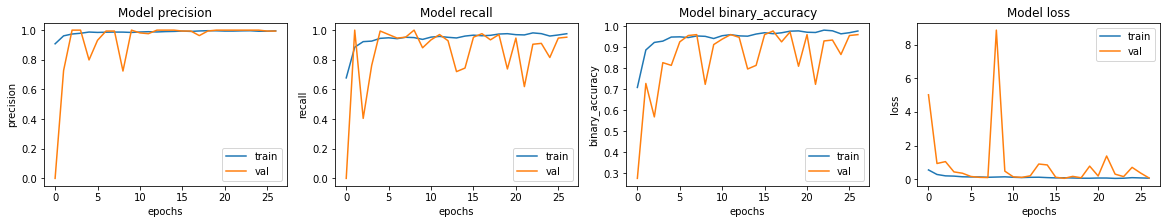

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

##08. 예측성능의 평가

In [20]:
model.evaluate(test_ds, return_dict=True)

4/4 [==============================] - 6s 991ms/step - loss: 2.0033 - binary_accuracy: 0.8045 - precision: 0.7669 - recall: 0.9872


{'binary_accuracy': 0.8044871687889099,
 'loss': 2.003289222717285,
 'precision': 0.7669321894645691,
 'recall': 0.9871795177459717}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  This is separate from the ipykernel package so we can avoid doing imports until


This image is 61.93 percent NORMAL
This image is 38.07 percent PNEUMONIA


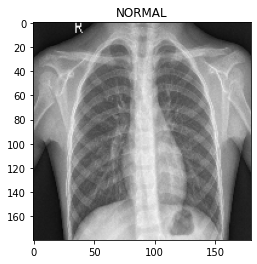

This image is 61.93 percent NORMAL
This image is 38.07 percent PNEUMONIA


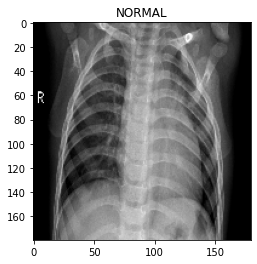

This image is 61.93 percent NORMAL
This image is 38.07 percent PNEUMONIA


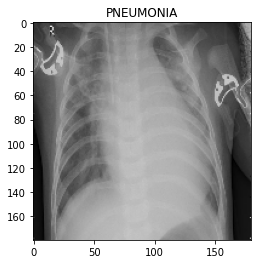

In [21]:
for image, label in test_ds.take(3):
    plt.imshow(image[0] / 255.0)
    plt.title(CLASS_NAMES[label[0].numpy()])

    prediction = model.predict(test_ds.take(1))[0]
    scores = [1 - prediction, prediction]

    for score, name in zip(scores, CLASS_NAMES):
      print("This image is %.2f percent %s" % ((100 * score), name))

    plt.show()

